In [24]:
#Load Dependecies
from ast import Return
from galvani import BioLogic
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from rich import print
from pathlib import Path
import re
import os
import json
from collections import defaultdict
from typing import Dict, Any
from scipy.signal import find_peaks
import ipywidgets as widgets # Benötigt für interaktive Elemente
from IPython.display import display, clear_output # 'display' zum Anzeigen von Widgets, 'clear_output' zum Aktualisieren des Plots


# Load the data

In [25]:
experimental_data = 'Test Data/NB_EC_002_02_CV_C01.mpr'

# plot the data

Anzahl der gefundenen Zyklen: 1

/var/folders/98/znc99q1n18nbfnvw103kf5p40000gn/T/ipykernel_66235/712033308.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1')


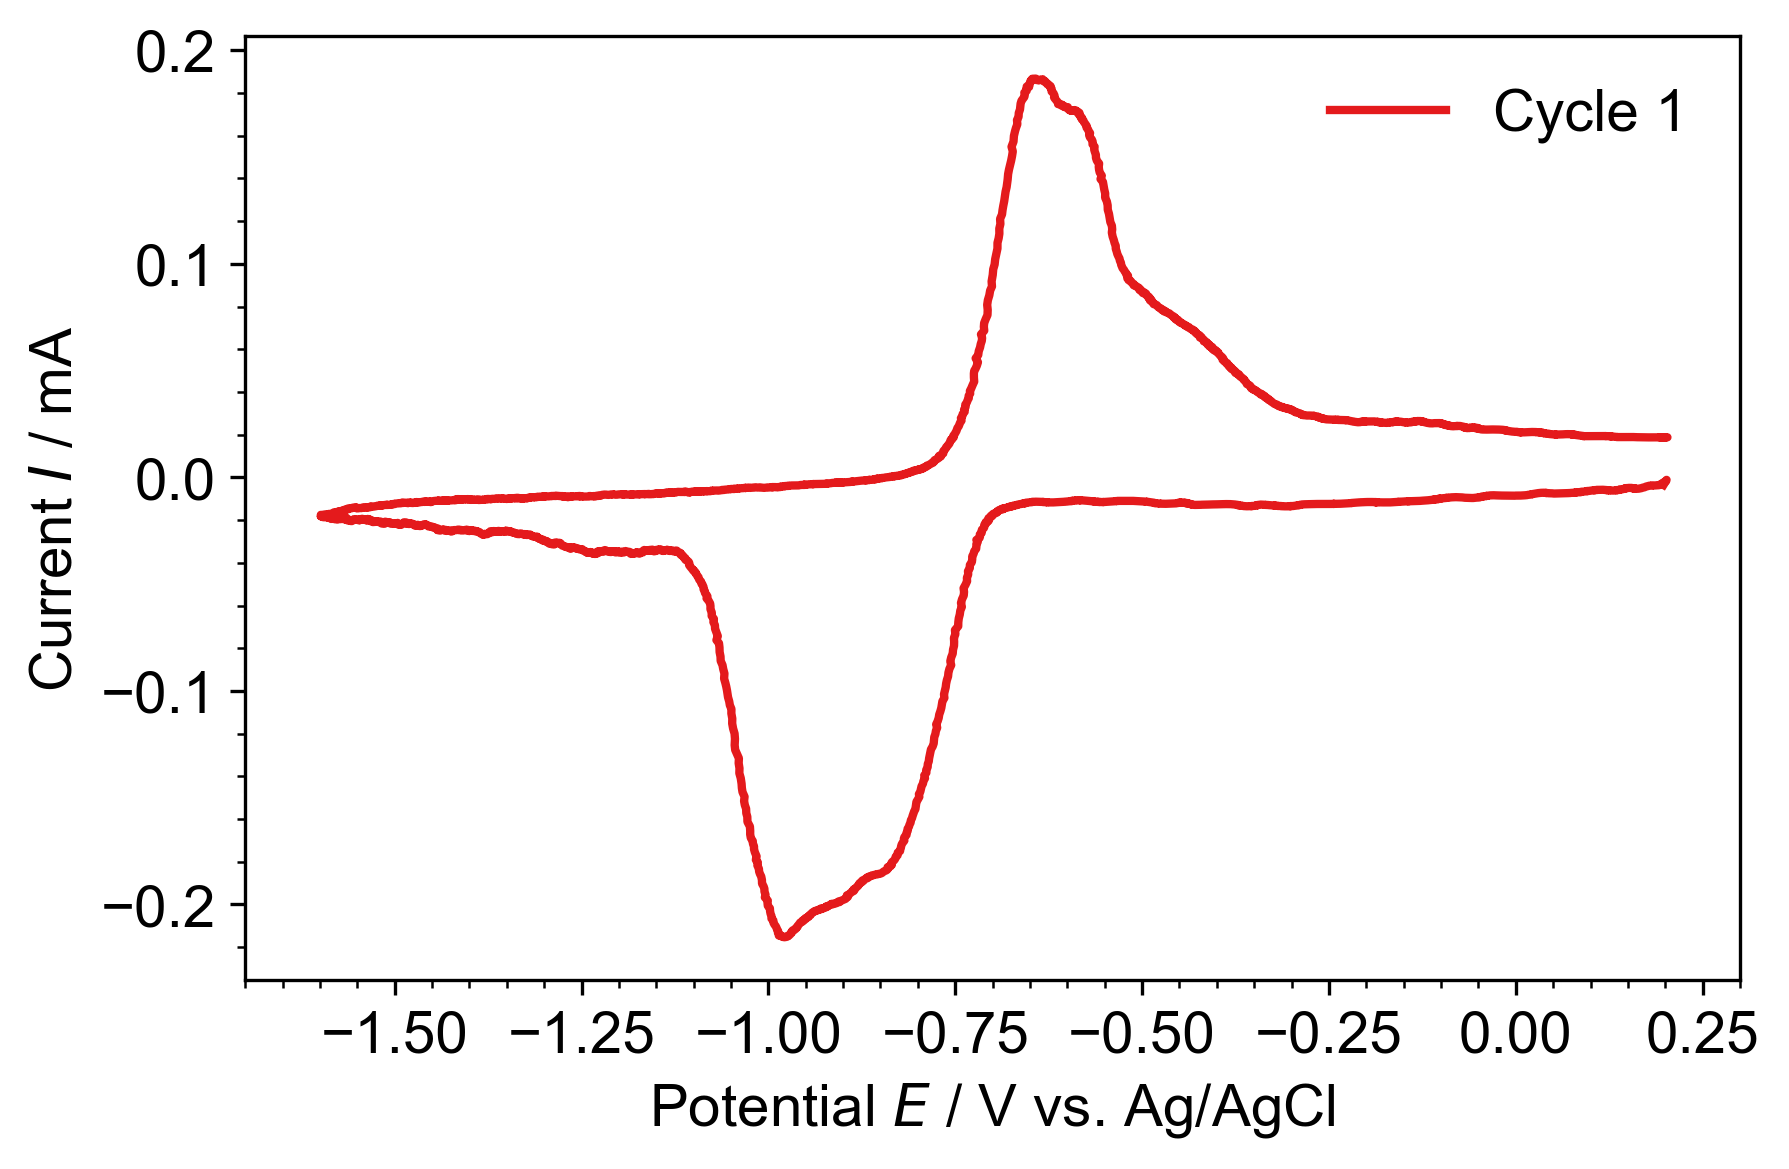

In [26]:
#Define your reference electrode and potential borders with x_min / x_max at the bottom




def plot_CV_cycles(file_to_plot=experimental_data, electrode_type="Ag/AgCl", x_min=-1.6, x_max=0.2):
    mpr_file = BioLogic.MPRfile(file_to_plot)
    df = pd.DataFrame(mpr_file.data)

    split_cycle = {cycle: group for cycle, group in df.groupby('cycle number')}
    cycle_data = {}
    num_cycles = len(split_cycle)
    print(f"Anzahl der gefundenen Zyklen: {num_cycles}")

    def safe_int(x):
        try:
            return int(float(x))
        except Exception:
            return str(x)

    def safe_float(x):
        try:
            return float(x)
        except Exception:
            return float('inf') 

    for cycle_num, group in split_cycle.items():
        potential_var_name = f"Potential_{safe_int(cycle_num)}"
        current_var_name = f"Current_{safe_int(cycle_num)}"
        cycle_data[potential_var_name] = group['Ewe/V'].copy()
        cycle_data[current_var_name] = group['<I>/mA'].copy()

    plt.figure(figsize=(6,4),dpi=300)
    cmap = cm.get_cmap('Set1')
    plt.rcParams['font.sans-serif'] = ['Aptos', 'Arial', 'Helvetica', 'DejaVu Sans']
    # Sortiere die Zyklen numerisch, falls möglich
    sorted_cycles = sorted(split_cycle.keys(), key=safe_float)
    for i, cycle_num in enumerate(sorted_cycles):
        group = split_cycle[cycle_num]
        color = cmap(i%10)
        label = f'Cycle {safe_int(cycle_num)}'
        plt.plot(group['Ewe/V'], group['<I>/mA'], label=label, color=color, lw=2)

#####Change the plot#######
    plt.xlabel(f'Potential $E$ / V vs. {electrode_type}', fontsize=14)
    plt.ylabel('Current $I$ / mA', fontsize=14)
    plt.legend(fontsize=14, frameon=False)
    plt.tick_params(axis='both', labelsize=14)
    plt.xlim((x_min-0.1),(x_max+0.1))
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()
#########################
    return cycle_data

cycle_data = plot_CV_cycles(
    file_to_plot= experimental_data,
    electrode_type="Ag/AgCl",
    x_min=-1.6,
    x_max=0.2
    )

# Parse metadata from .eps file

In [27]:
def parse_mps(file_path_mps):
    try:
        with open(file_path_mps, 'r', encoding='latin-1') as file:
            content = file.read()
        
        # Zeilenenden gescheit einheitlich machen 
        content = content.replace('\r\n', '\n').replace('\r', '\n')
        # Technique Abschnitte finden, splitten wenn Technique in file auftaucht
        technique_blocks = re.split(r'(?=Technique :)', content)
        metadata_block = technique_blocks.pop(0)
        print(f"Found {len(technique_blocks)} technique blocks")
        
        # Parse metadata
        metadata = {}
        for line in metadata_block.strip().split('\n'):
            if ':' in line:
                key, value = line.split(':', 1)
                metadata[key.strip()] = value.strip()
        
        # Parse techniques
        techniques = []
        all_params = set()
        for i, block in enumerate(technique_blocks):
            lines = [line for line in block.strip().split('\n') if line.strip()]
            if len(lines) < 2:
                continue
            technique_number = lines[0].split(':', 1)[1].strip()
            technique_name = lines[1].strip() if len(lines) > 1 else ''
            params = {}
            for line in lines[2:]:
                # Split on two or more spaces
                parts = re.split(r'\s{2,}', line.strip())
                if len(parts) == 2:
                    key, value = parts
                    params[key.strip()] = value.strip()
                    all_params.add(key.strip())
            
            # Create technique dictionary
            technique = {
                'number': technique_number,
                'name': technique_name,
                'parameters': params
            }
            techniques.append(technique)
        
        print(f"Parsed {len(techniques)} techniques with parameters: {sorted(list(all_params))}")
        return metadata, techniques, all_params
    except Exception as e:
        print(f"Error parsing file: {str(e)}")
        return {}, [], set()

def save_techniques_to_json(techniques, output_file):
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(techniques, f, indent=4, ensure_ascii=False)
        print(f"Successfully created {output_file}")
    except Exception as e:
        print(f"Error saving to JSON: {str(e)}")

def save_metadata_to_json(metadata, output_file):
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)
        print(f"Successfully created {output_file}")
    except Exception as e:
        print(f"Error saving to JSON: {str(e)}")

if __name__ == "__main__":
    file_path_mps = "Test Data/NB_EC_002.mps"
    #Extrakt file name
    base_name = os.path.splitext(os.path.basename(file_path_mps))[0]
    metadata_dir = "Metadata"
    os.makedirs(metadata_dir, exist_ok=True)
    output_techniques_json = os.path.join(metadata_dir, f"{base_name}_techniques.json")
    output_metadata_json = os.path.join(metadata_dir, f"{base_name}_metadata.json")
        
    metadata, techniques, all_params = parse_mps(file_path_mps)
    if techniques:
        save_techniques_to_json(techniques, output_techniques_json)
    if metadata:
        save_metadata_to_json(metadata, output_metadata_json)

Found 4 technique blocks

Parsed 4 techniques with parameters: ['Bandwidth', 'E range max (V)', 'E range min (V)', 'E1 (V)', 'E2 (V)', 'Ef 
(V)', 'Ei (V)', 'I Range', 'I Range init', 'I Range max', 'I Range min', 'N', 'Reverse Scan', 'Step percent', 
'dE/dt', 'dE/dt unit', 'dER (mV)', 'dER/dt (mV/h)', 'dtR (s)', 'nc cycles', 'record', 'tR (hⓂs)', 'vs.']

Successfully created Metadata/NB_EC_002_techniques.json

Successfully created Metadata/NB_EC_002_metadata.json

# peak finder

In [ ]:
def find_CV_peaks_interactive(
    file_path=experimental_data,
    prominence: float = 0.1,
    electrode_type="Ag/AgCl",
    x_min=-2.0,
    x_max=0.2
):
    """
    This function finds and plots peaks of the experimental data. It is currently just usable to find the global
    maximum, but will be improved in the future. 
    """
    
    try:
        mpr_path = Path(file_path)
        
        if not mpr_path.is_file():
            print(f"Fehler: Datei nicht gefunden: {mpr_path}")
            return

        mpr_file = BioLogic.MPRfile(str(mpr_path))
        df = pd.DataFrame(mpr_file.data)

        # group the cycles 
        split_cycle = {cycle: group for cycle, group in df.groupby('cycle number')}

        
        plt.figure(figsize=(6,4), dpi=300)
        plt.rcParams['font.sans-serif'] = ['Aptos', 'Arial', 'Helvetica', 'DejaVu Sans']

        all_peaks = []
        
        cmap = plt.cm.get_cmap('Set1')
        sorted_cycles = sorted(split_cycle.keys())

        # iterate over every cycle 
        for i, cycle in enumerate(sorted_cycles):
            group = split_cycle[cycle]
            potential = group['Ewe/V'].values
            current = group['<I>/mA'].values
            
            #anodic scan
            anodic_scan_mask = group['Ewe/V'].diff().gt(0)
            anodic_potential_series = group.loc[anodic_scan_mask, 'Ewe/V']
            anodic_current_series = group.loc[anodic_scan_mask, '<I>/mA']

            # cathodic scan
            cathodic_scan_mask = group['Ewe/V'].diff().lt(0)
            cathodic_potential_series = group.loc[cathodic_scan_mask, 'Ewe/V']
            cathodic_current_series = group.loc[cathodic_scan_mask, '<I>/mA']

            # anodic peak current
            anodic_peaks_indices, _ = find_peaks(anodic_current_series.values, prominence=prominence)
            anodic_peak_potentials = []
            anodic_peak_currents = []
            if len(anodic_peaks_indices) > 0: 
                anodic_peak_potentials = anodic_potential_series.iloc[anodic_peaks_indices].values
                anodic_peak_currents = anodic_current_series.iloc[anodic_peaks_indices].values

            #cathodic peak current (inverse values bc it works ^^)
            cathodic_peaks_indices, _ = find_peaks(-cathodic_current_series.values, prominence=prominence)
            cathodic_peak_potentials = []
            cathodic_peak_currents = []
            if len(cathodic_peaks_indices) > 0:
                cathodic_peak_potentials = cathodic_potential_series.iloc[cathodic_peaks_indices].values
                cathodic_peak_currents = cathodic_current_series.iloc[cathodic_peaks_indices].values # Originale Stromwerte beibehalten

            # save peak info
            cycle_peaks = {
                'cycle': int(cycle),
                'anodic_peaks': list(zip(anodic_peak_potentials, anodic_peak_currents)),
                'cathodic_peaks': list(zip(cathodic_peak_potentials, cathodic_peak_currents))
            }
            all_peaks.append(cycle_peaks)
            # reuses colors if more than 10 cycles 
            color = cmap(i % len(sorted_cycles)) 

            plt.plot(potential, current, label=f'Cycle {int(cycle)}', color=color)


            # show peaks in the plot
            if len(anodic_peak_potentials) > 0:
                plt.plot(anodic_peak_potentials, anodic_peak_currents, 'x', color='blue', markersize=5, mew=2, label="_nolegend_")
            if len(cathodic_peak_potentials) > 0:
                plt.plot(cathodic_peak_potentials, cathodic_peak_currents, 'o', color='blue', markersize=5, mew=2, label="_nolegend_")

        
        plt.xlabel(f'Potential $E$ / V vs. {electrode_type}', fontsize=14)
        plt.ylabel('Current $I$ / mA', fontsize=14)
        plt.legend(fontsize=14, frameon=False)
        plt.tick_params(axis='both', labelsize=14)
        plt.xlim((x_min-0.1),(x_max+0.1))
        plt.minorticks_on()
        plt.tight_layout()
        plt.show()

        # Peakdata in console 
        print("Found Peaks:")
        for cycle_data in all_peaks:
            print(f"\n--- Zyklus {cycle_data['cycle']} ---")
            print("anodic peaks (oxidation):")
            if cycle_data['anodic_peaks']:
                for potential, current in cycle_data['anodic_peaks']:
                    print(f"  - E = {potential:.4f} V, I = {current:.4f} mA")
            else:
                print("  no anodic peaks found.")
            
            print("cathodic peaks (reduction):")
            if cycle_data['cathodic_peaks']:
                for potential, current in cycle_data['cathodic_peaks']: # Korrigierter Tippfehler hier
                    print(f"  - E = {potential:.4f} V, I = {current:.4f} mA")
            else:
                print("no anodic peaks found.")

    except Exception as e:
        print(f"error occured: {e}")

# --- Create slider for prominence ---
prominence_slider = widgets.FloatSlider(
    value=0.001,        
    min=0.001,         
    max=0.05,           
    step=0.001,        
    description='Prominence:', 
    continuous_update=True, 
    orientation='horizontal',
    readout=True,      
    readout_format='.3f', 
    layout=widgets.Layout(width='600px') 
)

# --- Display widgets ---.
display(
    widgets.interactive(
        find_CV_peaks_interactive,
        file_path=widgets.fixed(experimental_data),  
        prominence=prominence_slider
    )
)

interactive(children=(FloatSlider(value=0.001, description='Prominence:', layout=Layout(width='600px'), max=0.…